# RNN with Pytorch

In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

In [3]:
train_data = datasets.MNIST(
        root='data/',
        train=True,    
        transform=transforms.ToTensor(),
        download=DOWNLOAD_MNIST,
)
test_data = datasets.MNIST(
        root='data/',
        train=False,    
        transform=transforms.ToTensor(),
        download=DOWNLOAD_MNIST,
)

torch.Size([60000, 28, 28])
torch.Size([60000])


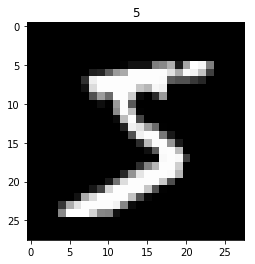

In [4]:
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(28, 64, 2)
        # self.lstm = nn.LSTM(28, 64, 2, batch_first=True)
        self.clf = nn.Linear(64,10)
    def forward(self, x):
        out, _ = self.lstm(x)        
        out = self.clf(out[-1,:,:])
        # out = self.clf(out[:,-1,:])
        return out

In [7]:
rnn = RNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-2)

In [10]:
num_epoches = 2
batch_size = BATCH_SIZE
for epoch in range(num_epoches):
    print('epoch {}'.format(epoch+1))
    print('*'*10)
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_loader, 1):
        img, label = data
        b, c, h, w = img.size() # batch, 1, 28, 28
        img = img.permute(3,0,1,2).contiguous().view(w,b,h) # 28,b,28
        # img = img.view(b,w,h)
        img = Variable(img)
        label = Variable(label)
        out = rnn(img)
        loss = criterion(out, label)
        running_loss += loss.data[0] * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred==label).sum()
        running_acc += num_correct.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 300 == 0:
            print('[{}/{}] Loss: {:.6f}, Acc: {:.6f}'.format(
                epoch+1, num_epoches,
                running_loss/(batch_size*i),
                running_acc/(batch_size*i)
            ))
    print('Finish {} epoch, Loss: {:.6f}, Acc: {:.6f}'.format(
        epoch+1,
        running_loss/(len(train_data)),
        running_acc/(len(train_data))
    ))

epoch 1
**********
[1/2] Loss: 0.162905, Acc: 0.953125
[1/2] Loss: 0.142473, Acc: 0.959167
[1/2] Loss: 0.133689, Acc: 0.961476
Finish 1 epoch, Loss: 0.133367, Acc: 0.961650
epoch 2
**********
[2/2] Loss: 0.099753, Acc: 0.971094
[2/2] Loss: 0.097710, Acc: 0.972214
[2/2] Loss: 0.095464, Acc: 0.972778
Finish 2 epoch, Loss: 0.094663, Acc: 0.972933
